# MNIST 성능향상 과제 

### 컴퓨터과학부 2014920044 이홍석

### 기본 예제 코드

1. 모듈 import

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data

np.random.seed(20160704)
tf.set_random_seed(20160704)

2. MNIST 다운로드

In [2]:
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


3. 첫번째 Convolution, Pooling Layer

In [3]:
num_filters1 = 32

x = tf.placeholder(tf.float32, [None, 784])
x_image = tf.reshape(x, [-1,28,28,1])

W_conv1 = tf.Variable(tf.truncated_normal([5,5,1,num_filters1],
                                          stddev=0.1))
h_conv1 = tf.nn.conv2d(x_image, W_conv1,
                       strides=[1,1,1,1], padding='SAME')

b_conv1 = tf.Variable(tf.constant(0.1, shape=[num_filters1]))
h_conv1_cutoff = tf.nn.relu(h_conv1 + b_conv1)

h_pool1 = tf.nn.max_pool(h_conv1_cutoff, ksize=[1,2,2,1],
                         strides=[1,2,2,1], padding='SAME')

4. 두번째 Convolution, Pooling Layer

In [4]:
num_filters2 = 64

W_conv2 = tf.Variable(
            tf.truncated_normal([5,5,num_filters1,num_filters2],
                                stddev=0.1))
h_conv2 = tf.nn.conv2d(h_pool1, W_conv2,
                       strides=[1,1,1,1], padding='SAME')

b_conv2 = tf.Variable(tf.constant(0.1, shape=[num_filters2]))
h_conv2_cutoff = tf.nn.relu(h_conv2 + b_conv2)

h_pool2 = tf.nn.max_pool(h_conv2_cutoff, ksize=[1,2,2,1],
                         strides=[1,2,2,1], padding='SAME')

5. 전 결합층, Dropout, Softmax

In [5]:
h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*num_filters2])

num_units1 = 7*7*num_filters2
num_units2 = 1024

w2 = tf.Variable(tf.truncated_normal([num_units1, num_units2]))
b2 = tf.Variable(tf.constant(0.1, shape=[num_units2]))
hidden2 = tf.nn.relu(tf.matmul(h_pool2_flat, w2) + b2)

keep_prob = tf.placeholder(tf.float32)
hidden2_drop = tf.nn.dropout(hidden2, keep_prob)

w0 = tf.Variable(tf.zeros([num_units2, 10]))
b0 = tf.Variable(tf.zeros([10]))
p = tf.nn.softmax(tf.matmul(hidden2_drop, w0) + b0)

6. Loss 함수 정의(Categorical Entropy), Adam, Accuracy 정의

In [6]:
t = tf.placeholder(tf.float32, [None, 10])
loss = -tf.reduce_sum(t * tf.log(p))
train_step = tf.train.AdamOptimizer(0.0001).minimize(loss)
correct_prediction = tf.equal(tf.argmax(p, 1), tf.argmax(t, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

7. 세션 정의, 변수 초기화, Saver사용

In [7]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()

8. Training

In [10]:
i = 0
for _ in range(20000):
    i += 1
    batch_xs, batch_ts = mnist.train.next_batch(50)
    sess.run(train_step,
             feed_dict={x:batch_xs, t:batch_ts, keep_prob:0.5})
    if i % 500 == 0:
        loss_val, acc_val = sess.run([loss, accuracy],
        feed_dict={x:mnist.test.images,
                           t:mnist.test.labels,
                           keep_prob:1.0})
        print ('Step: %d, Loss: %f, Accuracy: %f'% (i, loss_val, acc_val))
        saver.save(sess,'C:/Users/dlghd/env/Scripts/Project/cnn_session', global_step=i)

Step: 500, Loss: 939.515259, Accuracy: 0.972000
Step: 1000, Loss: 748.143250, Accuracy: 0.976700
Step: 1500, Loss: 620.812683, Accuracy: 0.978800
Step: 2000, Loss: 598.708191, Accuracy: 0.979700
Step: 2500, Loss: 541.033020, Accuracy: 0.982400
Step: 3000, Loss: 466.373352, Accuracy: 0.983800
Step: 3500, Loss: 470.150116, Accuracy: 0.984700
Step: 4000, Loss: 413.453979, Accuracy: 0.985300
Step: 4500, Loss: 395.551208, Accuracy: 0.986000
Step: 5000, Loss: 406.855713, Accuracy: 0.985700
Step: 5500, Loss: 382.315552, Accuracy: 0.987400
Step: 6000, Loss: 348.944519, Accuracy: 0.988100
Step: 6500, Loss: 366.545532, Accuracy: 0.987200
Step: 7000, Loss: 347.834320, Accuracy: 0.987500
Step: 7500, Loss: 357.540588, Accuracy: 0.988000
Step: 8000, Loss: 342.187317, Accuracy: 0.988300
Step: 8500, Loss: 335.171570, Accuracy: 0.988900
Step: 9000, Loss: 316.791473, Accuracy: 0.989900
Step: 9500, Loss: 335.758942, Accuracy: 0.989300
Step: 10000, Loss: 326.414734, Accuracy: 0.988300
Step: 10500, Loss: 3

9. 첫번째 Layer(Cutoff 적용X)

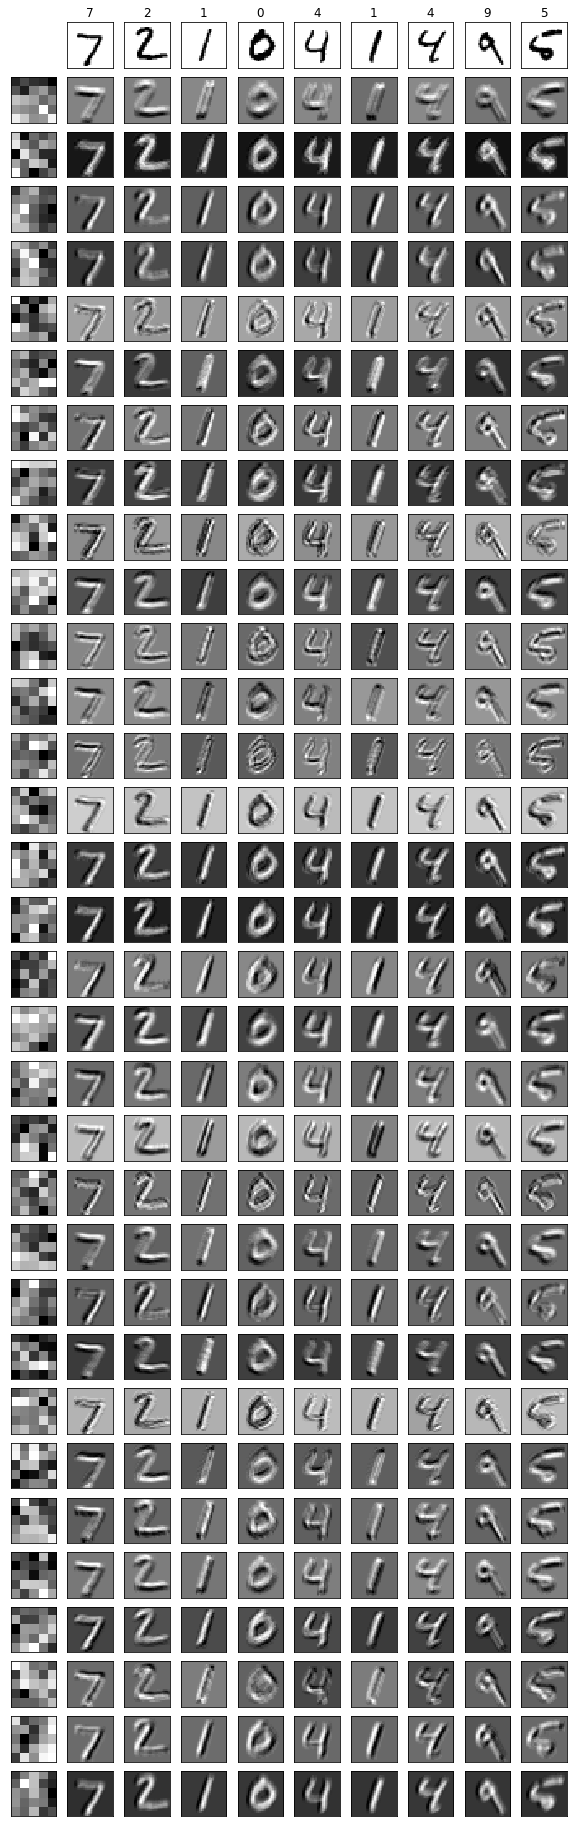

In [17]:
filter1_vals, conv1_vals, pool1_vals = sess.run(
    [W_conv1, h_conv1, h_pool1], feed_dict={x:mnist.test.images[:9]})
fig = plt.figure(figsize=(10,num_filters1+1))

for i in range(num_filters1):
    subplot = fig.add_subplot(num_filters1+1, 10, 10*(i+1)+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(filter1_vals[:,:,0,i],
                   cmap=plt.cm.gray_r, interpolation='nearest')

for i in range(9):
    subplot = fig.add_subplot(num_filters1+1, 10, i+2)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.set_title('%d' % np.argmax(mnist.test.labels[i]))
    subplot.imshow(mnist.test.images[i].reshape((28,28)),
                   vmin=0, vmax=1,
                   cmap=plt.cm.gray_r, interpolation='nearest')

    for f in range(num_filters1):
        subplot = fig.add_subplot(num_filters1+1, 10, 10*(f+1)+i+2)
        subplot.set_xticks([])
        subplot.set_yticks([])
        subplot.imshow(conv1_vals[i,:,:,f],
                       cmap=plt.cm.gray_r, interpolation='nearest')    

10. 첫번째 Layer(Cutoff 적용O)

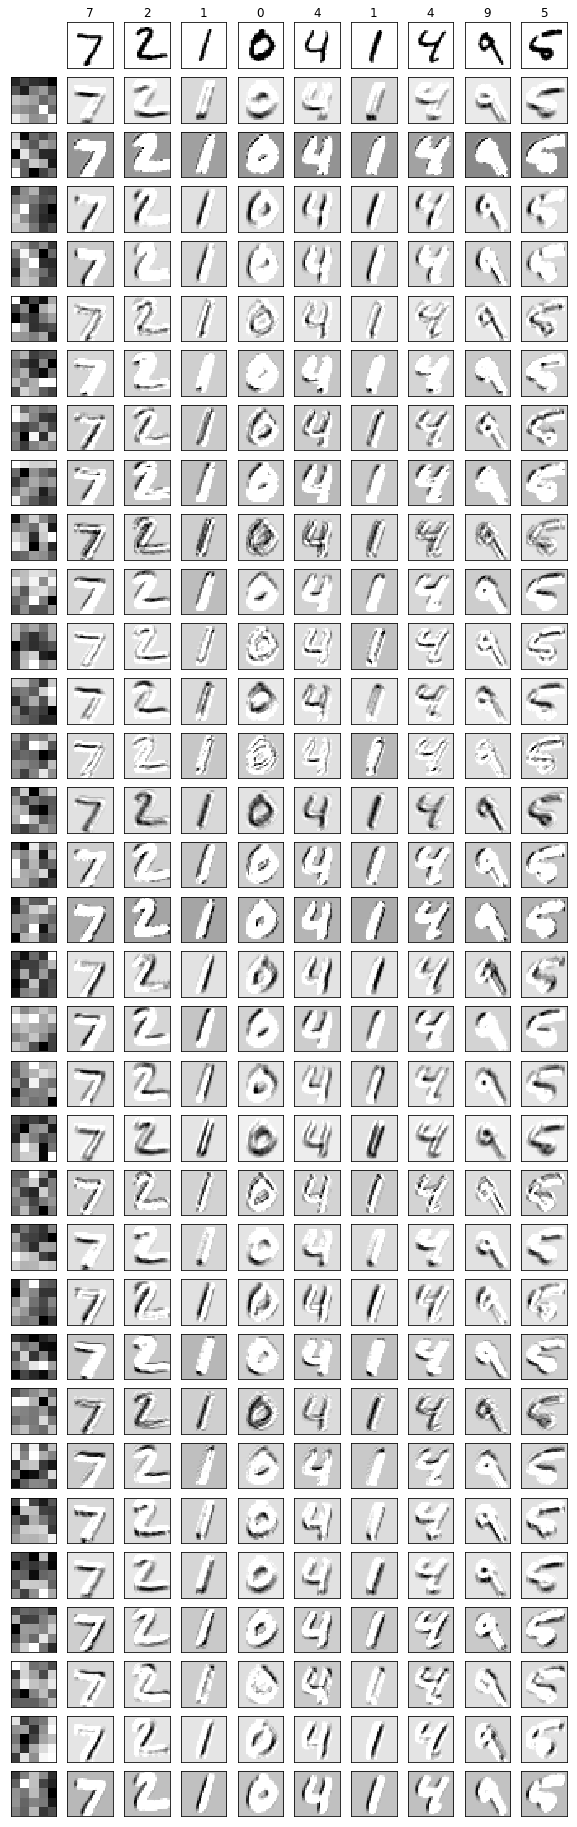

In [19]:
filter1_vals, conv1_vals, pool1_vals = sess.run(
    [W_conv1, h_conv1_cutoff, h_pool1], feed_dict={x:mnist.test.images[:9]})
fig = plt.figure(figsize=(10,num_filters1+1))

for i in range(num_filters1):
    subplot = fig.add_subplot(num_filters1+1, 10, 10*(i+1)+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(filter1_vals[:,:,0,i],
                   cmap=plt.cm.gray_r, interpolation='nearest')

for i in range(9):
    subplot = fig.add_subplot(num_filters1+1, 10, i+2)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.set_title('%d' % np.argmax(mnist.test.labels[i]))
    subplot.imshow(mnist.test.images[i].reshape((28,28)),
                   vmin=0, vmax=1,
                   cmap=plt.cm.gray_r, interpolation='nearest')

    for f in range(num_filters1):
        subplot = fig.add_subplot(num_filters1+1, 10, 10*(f+1)+i+2)
        subplot.set_xticks([])
        subplot.set_yticks([])
        subplot.imshow(conv1_vals[i,:,:,f],
                       cmap=plt.cm.gray_r, interpolation='nearest')    

11. 두번째 Layer(Cutoff 적용 X)

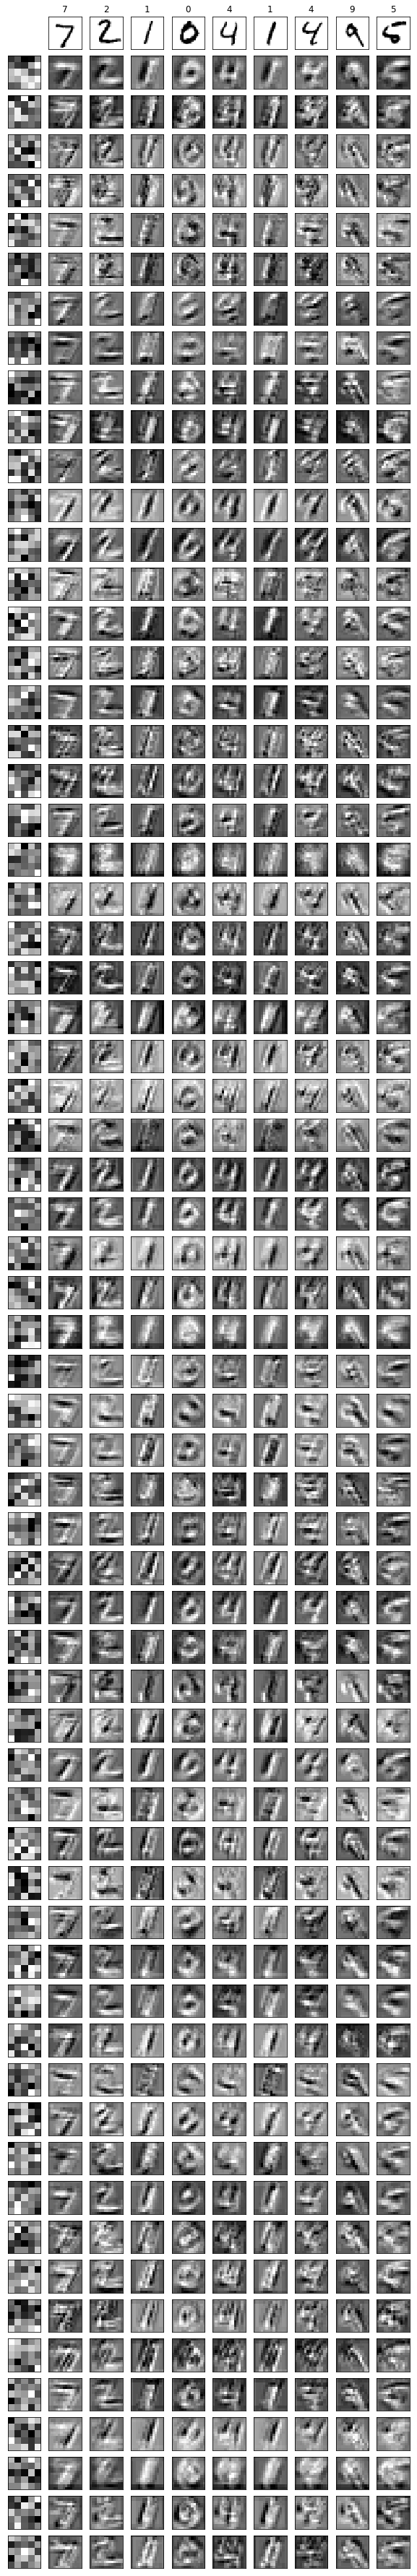

In [18]:
filter2_vals, conv2_vals, pool2_vals = sess.run(
    [W_conv2, h_conv2, h_pool2], feed_dict={x:mnist.test.images[:9]})
fig = plt.figure(figsize=(10,num_filters2+1))

for i in range(num_filters2):
    subplot = fig.add_subplot(num_filters2+1, 10, 10*(i+1)+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(filter2_vals[:,:,0,i],
                   cmap=plt.cm.gray_r, interpolation='nearest')

for i in range(9):
    subplot = fig.add_subplot(num_filters2+1, 10, i+2)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.set_title('%d' % np.argmax(mnist.test.labels[i]))
    subplot.imshow(mnist.test.images[i].reshape((28,28)),
                   vmin=0, vmax=1,
                   cmap=plt.cm.gray_r, interpolation='nearest')

    for f in range(num_filters2):
        subplot = fig.add_subplot(num_filters2+1, 10, 10*(f+1)+i+2)
        subplot.set_xticks([])
        subplot.set_yticks([])
        subplot.imshow(conv2_vals[i,:,:,f],
                       cmap=plt.cm.gray_r, interpolation='nearest')

12. 두번재 Layer(Cutoff 적용 O)

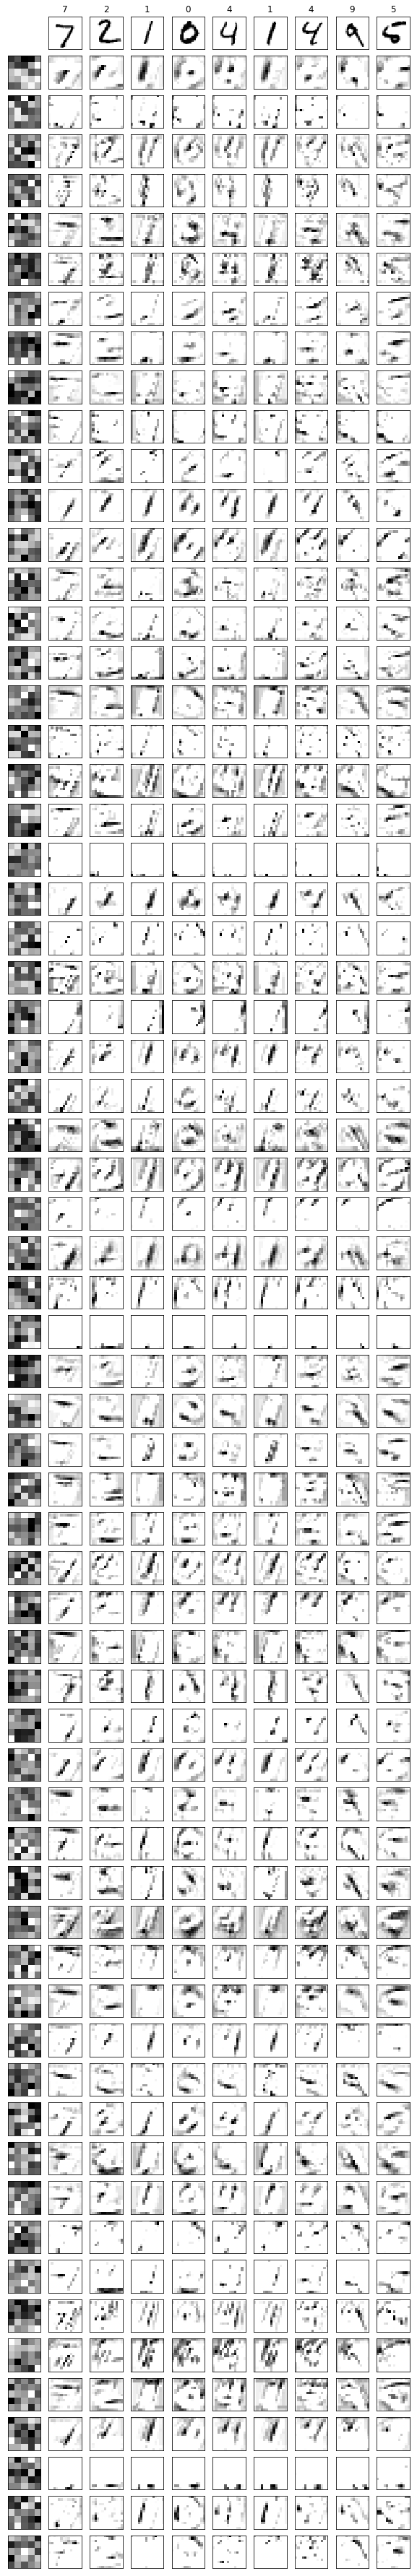

In [20]:
filter2_vals, conv2_vals, pool2_vals = sess.run(
    [W_conv2, h_conv2_cutoff, h_pool2], feed_dict={x:mnist.test.images[:9]})
fig = plt.figure(figsize=(10,num_filters2+1))

for i in range(num_filters2):
    subplot = fig.add_subplot(num_filters2+1, 10, 10*(i+1)+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(filter2_vals[:,:,0,i],
                   cmap=plt.cm.gray_r, interpolation='nearest')

for i in range(9):
    subplot = fig.add_subplot(num_filters2+1, 10, i+2)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.set_title('%d' % np.argmax(mnist.test.labels[i]))
    subplot.imshow(mnist.test.images[i].reshape((28,28)),
                   vmin=0, vmax=1,
                   cmap=plt.cm.gray_r, interpolation='nearest')

    for f in range(num_filters2):
        subplot = fig.add_subplot(num_filters2+1, 10, 10*(f+1)+i+2)
        subplot.set_xticks([])
        subplot.set_yticks([])
        subplot.imshow(conv2_vals[i,:,:,f],
                       cmap=plt.cm.gray_r, interpolation='nearest')

### 실험 목표

기본 코드를 활용하여 Accuracy가 0.9924까지 올라가는 것을 볼 수 있었습니다. 
다른 인자들을 조절하여 0.995이상 올리는 것을 목표로 하겠습니다.
필터출력은 문서가 매우 길어질 수 있으므로 기본코드와 결과가 가장 잘 나오는 코드만 출력하겠습니다.
사용한 툴은 tensorflow-gpu이고 사용한 그래픽카드는 GTX1060 6GB 입니다.

### 실험 결과

#### 1. Hidden Layer의 수 조절

##### 1) 3개

In [ ]:
num_filters1 = 32

x = tf.placeholder(tf.float32, [None, 784])
x_image = tf.reshape(x, [-1,28,28,1])

W_conv1 = tf.Variable(tf.truncated_normal([5,5,1,num_filters1],
                                          stddev=0.1))
h_conv1 = tf.nn.conv2d(x_image, W_conv1,
                       strides=[1,1,1,1], padding='SAME')

b_conv1 = tf.Variable(tf.constant(0.1, shape=[num_filters1]))
h_conv1_cutoff = tf.nn.sigmoid(h_conv1 + b_conv1)

h_pool1 = tf.nn.max_pool(h_conv1_cutoff, ksize=[1,2,2,1],
                         strides=[1,2,2,1], padding='SAME')

num_filters2 = 64

W_conv2 = tf.Variable(
            tf.truncated_normal([5,5,num_filters1,num_filters2],
                                stddev=0.1))
h_conv2 = tf.nn.conv2d(h_pool1, W_conv2,
                       strides=[1,1,1,1], padding='SAME')

b_conv2 = tf.Variable(tf.constant(0.1, shape=[num_filters2]))
h_conv2_cutoff = tf.nn.sigmoid(h_conv2 + b_conv2)

h_pool2 = tf.nn.max_pool(h_conv2_cutoff, ksize=[1,2,2,1],
                         strides=[1,2,2,1], padding='SAME')

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*num_filters2])

num_units1 = 7*7*num_filters2
num_units2 = 1024

w2 = tf.Variable(tf.truncated_normal([num_units1, num_units2]))
b2 = tf.Variable(tf.constant(0.1, shape=[num_units2]))
hidden2 = tf.nn.sigmoid(tf.matmul(h_pool2_flat, w2) + b2)

keep_prob = tf.placeholder(tf.float32)
hidden2_drop = tf.nn.dropout(hidden2, keep_prob)

w0 = tf.Variable(tf.zeros([num_units2, 10]))
b0 = tf.Variable(tf.zeros([10]))
p = tf.nn.softmax(tf.matmul(hidden2_drop, w0) + b0)

t = tf.placeholder(tf.float32, [None, 10])
loss = -tf.reduce_sum(t * tf.log(p))
train_step = tf.train.AdamOptimizer(0.0001).minimize(loss)
correct_prediction = tf.equal(tf.argmax(p, 1), tf.argmax(t, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

gpu_options = tf.GPUOptions(allow_growth=True)
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))
sess.run(tf.global_variables_initializer())

i = 0
for _ in range(40000):
    i += 1
    batch_xs, batch_ts = mnist.train.next_batch(50)
    sess.run(train_step,
             feed_dict={x:batch_xs, t:batch_ts, keep_prob:0.5})
    if i % 500 == 0:
        loss_vals, acc_vals = [], []
        for c in range(4):
            start = int(len(mnist.test.labels) / 4 * c)
            end = int(len(mnist.test.labels) / 4 * (c+1))
            loss_val, acc_val = sess.run([loss, accuracy],
                feed_dict={x:mnist.test.images[start:end],
                           t:mnist.test.labels[start:end],
                           keep_prob:1.0})
            loss_vals.append(loss_val)
            acc_vals.append(acc_val)
        loss_val = np.sum(loss_vals)
        acc_val = np.mean(acc_vals)
        print ('Step: %d, Loss: %f, Accuracy: %f'
               % (i, loss_val, acc_val))

##### 2) 4개

##### 3) 5개

#### 2. Node 수 조절

##### 1) 512

In [5]:
h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*num_filters2])

num_units1 = 7*7*num_filters2
num_units2 = 512

w2 = tf.Variable(tf.truncated_normal([num_units1, num_units2]))
b2 = tf.Variable(tf.constant(0.1, shape=[num_units2]))
hidden2 = tf.nn.relu(tf.matmul(h_pool2_flat, w2) + b2)

keep_prob = tf.placeholder(tf.float32)
hidden2_drop = tf.nn.dropout(hidden2, keep_prob)

w0 = tf.Variable(tf.zeros([num_units2, 10]))
b0 = tf.Variable(tf.zeros([10]))
p = tf.nn.softmax(tf.matmul(hidden2_drop, w0) + b0)

t = tf.placeholder(tf.float32, [None, 10])
loss = -tf.reduce_sum(t * tf.log(p))
train_step = tf.train.AdamOptimizer(0.0001).minimize(loss)
correct_prediction = tf.equal(tf.argmax(p, 1), tf.argmax(t, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

i = 0
for _ in range(20000):
    i += 1
    batch_xs, batch_ts = mnist.train.next_batch(50)
    sess.run(train_step,
             feed_dict={x:batch_xs, t:batch_ts, keep_prob:0.5})
    if i % 500 == 0:
        loss_val, acc_val = sess.run([loss, accuracy],
        feed_dict={x:mnist.test.images,
                           t:mnist.test.labels,
                           keep_prob:1.0})
        print ('Step: %d, Loss: %f, Accuracy: %f'% (i, loss_val, acc_val))

Step: 500, Loss: 1896.490845, Accuracy: 0.944500
Step: 1000, Loss: 1260.288818, Accuracy: 0.965100
Step: 1500, Loss: 915.675659, Accuracy: 0.970500
Step: 2000, Loss: 796.199158, Accuracy: 0.976100
Step: 2500, Loss: 691.589722, Accuracy: 0.979000
Step: 3000, Loss: 666.970825, Accuracy: 0.978800
Step: 3500, Loss: 589.258423, Accuracy: 0.981600
Step: 4000, Loss: 560.586365, Accuracy: 0.982900
Step: 4500, Loss: 484.977600, Accuracy: 0.983900
Step: 5000, Loss: 478.736816, Accuracy: 0.984100
Step: 5500, Loss: 499.587769, Accuracy: 0.985100
Step: 6000, Loss: 445.133362, Accuracy: 0.984800
Step: 6500, Loss: 435.084229, Accuracy: 0.985300
Step: 7000, Loss: 462.203674, Accuracy: 0.984300
Step: 7500, Loss: 410.770844, Accuracy: 0.986700
Step: 8000, Loss: 424.998718, Accuracy: 0.986800
Step: 8500, Loss: 377.338745, Accuracy: 0.987900
Step: 9000, Loss: 360.023682, Accuracy: 0.988400
Step: 9500, Loss: 397.136688, Accuracy: 0.986900
Step: 10000, Loss: 379.151520, Accuracy: 0.988100
Step: 10500, Loss:

1024개의 노드를 사용했을때 보다 Accuracy가 조금 떨어진 것을 볼 수 있었습니다만, 거의 차이가 없었습니다.

##### 2) 2048

In [5]:
h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*num_filters2])

num_units1 = 7*7*num_filters2
num_units2 = 2048

w2 = tf.Variable(tf.truncated_normal([num_units1, num_units2]))
b2 = tf.Variable(tf.constant(0.1, shape=[num_units2]))
hidden2 = tf.nn.relu(tf.matmul(h_pool2_flat, w2) + b2)

keep_prob = tf.placeholder(tf.float32)
hidden2_drop = tf.nn.dropout(hidden2, keep_prob)

w0 = tf.Variable(tf.zeros([num_units2, 10]))
b0 = tf.Variable(tf.zeros([10]))
p = tf.nn.softmax(tf.matmul(hidden2_drop, w0) + b0)

t = tf.placeholder(tf.float32, [None, 10])
loss = -tf.reduce_sum(t * tf.log(p))
train_step = tf.train.AdamOptimizer(0.0001).minimize(loss)
correct_prediction = tf.equal(tf.argmax(p, 1), tf.argmax(t, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

i = 0
for _ in range(20000):
    i += 1
    batch_xs, batch_ts = mnist.train.next_batch(50)
    sess.run(train_step,
             feed_dict={x:batch_xs, t:batch_ts, keep_prob:0.5})
    if i % 500 == 0:
        loss_val, acc_val = sess.run([loss, accuracy],
        feed_dict={x:mnist.test.images,
                           t:mnist.test.labels,
                           keep_prob:1.0})
        print ('Step: %d, Loss: %f, Accuracy: %f'% (i, loss_val, acc_val))

Step: 500, Loss: 1254.482422, Accuracy: 0.960300
Step: 1000, Loss: 766.927612, Accuracy: 0.976200
Step: 1500, Loss: 660.201538, Accuracy: 0.979100
Step: 2000, Loss: 511.684357, Accuracy: 0.983000
Step: 2500, Loss: 524.530945, Accuracy: 0.983300
Step: 3000, Loss: 437.897034, Accuracy: 0.984400
Step: 3500, Loss: 434.069214, Accuracy: 0.985600
Step: 4000, Loss: 444.409363, Accuracy: 0.985000
Step: 4500, Loss: 358.334961, Accuracy: 0.987700
Step: 5000, Loss: 408.559875, Accuracy: 0.986800
Step: 5500, Loss: 357.997009, Accuracy: 0.988600
Step: 6000, Loss: 356.999146, Accuracy: 0.988000
Step: 6500, Loss: 348.570312, Accuracy: 0.987900
Step: 7000, Loss: 351.692932, Accuracy: 0.987800
Step: 7500, Loss: 323.326599, Accuracy: 0.989300
Step: 8000, Loss: 390.209137, Accuracy: 0.986800
Step: 8500, Loss: 319.656097, Accuracy: 0.988700
Step: 9000, Loss: 346.321228, Accuracy: 0.988600
Step: 9500, Loss: 354.499268, Accuracy: 0.988000
Step: 10000, Loss: 322.220978, Accuracy: 0.989400
Step: 10500, Loss: 

노드의 수를 2048개로 늘렸지만 512개나 1024개와 별다른 차이가 없었습니다.

##### 3) 4096

In [6]:
h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*num_filters2])

num_units1 = 7*7*num_filters2
num_units2 = 4096

w2 = tf.Variable(tf.truncated_normal([num_units1, num_units2]))
b2 = tf.Variable(tf.constant(0.1, shape=[num_units2]))
hidden2 = tf.nn.relu(tf.matmul(h_pool2_flat, w2) + b2)

keep_prob = tf.placeholder(tf.float32)
hidden2_drop = tf.nn.dropout(hidden2, keep_prob)

w0 = tf.Variable(tf.zeros([num_units2, 10]))
b0 = tf.Variable(tf.zeros([10]))
p = tf.nn.softmax(tf.matmul(hidden2_drop, w0) + b0)

t = tf.placeholder(tf.float32, [None, 10])
loss = -tf.reduce_sum(t * tf.log(p))
train_step = tf.train.AdamOptimizer(0.00001).minimize(loss)
correct_prediction = tf.equal(tf.argmax(p, 1), tf.argmax(t, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

i = 0
for _ in range(20000):
    i += 1
    batch_xs, batch_ts = mnist.train.next_batch(50)
    sess.run(train_step,
             feed_dict={x:batch_xs, t:batch_ts, keep_prob:0.5})
    if i % 500 == 0:
        loss_val, acc_val = sess.run([loss, accuracy],
        feed_dict={x:mnist.test.images,
                           t:mnist.test.labels,
                           keep_prob:1.0})
        print ('Step: %d, Loss: %f, Accuracy: %f'% (i, loss_val, acc_val))

Step: 500, Loss: 2734.656982, Accuracy: 0.933100
Step: 1000, Loss: 1884.107422, Accuracy: 0.946900
Step: 1500, Loss: 1510.913818, Accuracy: 0.959300
Step: 2000, Loss: 1320.133301, Accuracy: 0.963400
Step: 2500, Loss: 1088.236206, Accuracy: 0.968500
Step: 3000, Loss: 951.666626, Accuracy: 0.973000
Step: 3500, Loss: 866.641113, Accuracy: 0.974100
Step: 4000, Loss: 816.086548, Accuracy: 0.974700
Step: 4500, Loss: 825.387756, Accuracy: 0.974800
Step: 5000, Loss: 690.191528, Accuracy: 0.978600
Step: 5500, Loss: 640.942383, Accuracy: 0.979900
Step: 6000, Loss: 684.692932, Accuracy: 0.977300
Step: 6500, Loss: 605.291809, Accuracy: 0.981600
Step: 7000, Loss: 603.093811, Accuracy: 0.979400
Step: 7500, Loss: 521.719116, Accuracy: 0.984300
Step: 8000, Loss: 532.002319, Accuracy: 0.982500
Step: 8500, Loss: 537.785461, Accuracy: 0.982400
Step: 9000, Loss: 477.809631, Accuracy: 0.983800
Step: 9500, Loss: 460.024841, Accuracy: 0.984500
Step: 10000, Loss: 504.355652, Accuracy: 0.982400
Step: 10500, Lo

In [8]:
i = 20000
for _ in range(20000):
    i += 1
    batch_xs, batch_ts = mnist.train.next_batch(50)
    sess.run(train_step,
             feed_dict={x:batch_xs, t:batch_ts, keep_prob:0.5})
    if i % 500 == 0:
        loss_val, acc_val = sess.run([loss, accuracy],
        feed_dict={x:mnist.test.images,
                           t:mnist.test.labels,
                           keep_prob:1.0})
        print ('Step: %d, Loss: %f, Accuracy: %f'% (i, loss_val, acc_val))

Step: 20500, Loss: 315.924774, Accuracy: 0.989200
Step: 21000, Loss: 349.568329, Accuracy: 0.987900
Step: 21500, Loss: 299.672668, Accuracy: 0.989300
Step: 22000, Loss: 315.546631, Accuracy: 0.989200
Step: 22500, Loss: 359.357330, Accuracy: 0.987700
Step: 23000, Loss: 331.755920, Accuracy: 0.989700
Step: 23500, Loss: 309.274261, Accuracy: 0.989000
Step: 24000, Loss: 302.469482, Accuracy: 0.989600
Step: 24500, Loss: 313.097717, Accuracy: 0.989300
Step: 25000, Loss: 294.969177, Accuracy: 0.989700
Step: 25500, Loss: 316.237610, Accuracy: 0.989100
Step: 26000, Loss: 300.796783, Accuracy: 0.989600
Step: 26500, Loss: 310.818665, Accuracy: 0.989300
Step: 27000, Loss: 289.039337, Accuracy: 0.990100
Step: 27500, Loss: 309.145660, Accuracy: 0.988900
Step: 28000, Loss: 302.287445, Accuracy: 0.990400
Step: 28500, Loss: 283.078613, Accuracy: 0.990600
Step: 29000, Loss: 279.286499, Accuracy: 0.990300
Step: 29500, Loss: 289.634277, Accuracy: 0.990300
Step: 30000, Loss: 302.034790, Accuracy: 0.989000


4096개의 노드를 이용했을때는 어디선가 범위가 초과됬거나 잘못 나누어서 Nan이라는 결과가 나왔습니다. 따라서 학습률을 0.00001로 낮추어서 진행하였습니다. 노드의 개수가 늘어나서 학습속도가 위의 다른 결과들에 비해 느립니다. 따라서 총 40000회를 학습시켰습니다. 실험결과, 전 결합층의 노드의 개수는 Accuracy에 그다지 영향이 없었습니다.

#### 3. Filter 수 조절

##### 1) 64, 128

In [26]:
num_filters1 = 64

x = tf.placeholder(tf.float32, [None, 784])
x_image = tf.reshape(x, [-1,28,28,1])

W_conv1 = tf.Variable(tf.truncated_normal([5,5,1,num_filters1],
                                          stddev=0.1))
h_conv1 = tf.nn.conv2d(x_image, W_conv1,
                       strides=[1,1,1,1], padding='SAME')

b_conv1 = tf.Variable(tf.constant(0.1, shape=[num_filters1]))
h_conv1_cutoff = tf.nn.relu(h_conv1 + b_conv1)

h_pool1 = tf.nn.max_pool(h_conv1_cutoff, ksize=[1,2,2,1],
                         strides=[1,2,2,1], padding='SAME')

num_filters2 = 128

W_conv2 = tf.Variable(
            tf.truncated_normal([5,5,num_filters1,num_filters2],
                                stddev=0.1))
h_conv2 = tf.nn.conv2d(h_pool1, W_conv2,
                       strides=[1,1,1,1], padding='SAME')

b_conv2 = tf.Variable(tf.constant(0.1, shape=[num_filters2]))
h_conv2_cutoff = tf.nn.relu(h_conv2 + b_conv2)

h_pool2 = tf.nn.max_pool(h_conv2_cutoff, ksize=[1,2,2,1],
                         strides=[1,2,2,1], padding='SAME')

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*num_filters2])

num_units1 = 7*7*num_filters2
num_units2 = 2048

w2 = tf.Variable(tf.truncated_normal([num_units1, num_units2]))
b2 = tf.Variable(tf.constant(0.1, shape=[num_units2]))
hidden2 = tf.nn.relu(tf.matmul(h_pool2_flat, w2) + b2)

keep_prob = tf.placeholder(tf.float32)
hidden2_drop = tf.nn.dropout(hidden2, keep_prob)

w0 = tf.Variable(tf.zeros([num_units2, 10]))
b0 = tf.Variable(tf.zeros([10]))
p = tf.nn.softmax(tf.matmul(hidden2_drop, w0) + b0)

t = tf.placeholder(tf.float32, [None, 10])
loss = -tf.reduce_sum(t * tf.log(p))
train_step = tf.train.AdamOptimizer(0.00001).minimize(loss)
correct_prediction = tf.equal(tf.argmax(p, 1), tf.argmax(t, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

gpu_options = tf.GPUOptions(allow_growth=True)
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))
sess.run(tf.global_variables_initializer())

i = 0
for _ in range(20000):
    i += 1
    batch_xs, batch_ts = mnist.train.next_batch(25)
    sess.run(train_step,
             feed_dict={x:batch_xs, t:batch_ts, keep_prob:0.5})
    if i % 500 == 0:
        loss_vals, acc_vals = [], []
        for c in range(4):
            start = int(len(mnist.test.labels) / 4 * c)
            end = int(len(mnist.test.labels) / 4 * (c+1))
            loss_val, acc_val = sess.run([loss, accuracy],
                feed_dict={x:mnist.test.images[start:end],
                           t:mnist.test.labels[start:end],
                           keep_prob:1.0})
            loss_vals.append(loss_val)
            acc_vals.append(acc_val)
        loss_val = np.sum(loss_vals)
        acc_val = np.mean(acc_vals)
        print ('Step: %d, Loss: %f, Accuracy: %f'
               % (i, loss_val, acc_val))

Step: 500, Loss: 3228.484375, Accuracy: 0.911100
Step: 1000, Loss: 2161.652100, Accuracy: 0.943100
Step: 1500, Loss: 1740.752930, Accuracy: 0.950500
Step: 2000, Loss: 1543.519775, Accuracy: 0.958400
Step: 2500, Loss: 1377.845459, Accuracy: 0.960800
Step: 3000, Loss: 1203.959229, Accuracy: 0.966100
Step: 3500, Loss: 1083.915405, Accuracy: 0.969000
Step: 4000, Loss: 1109.788818, Accuracy: 0.966400
Step: 4500, Loss: 959.912109, Accuracy: 0.971100
Step: 5000, Loss: 913.177124, Accuracy: 0.973000
Step: 5500, Loss: 835.292969, Accuracy: 0.974800
Step: 6000, Loss: 796.975220, Accuracy: 0.976400
Step: 6500, Loss: 849.597046, Accuracy: 0.975100
Step: 7000, Loss: 794.585510, Accuracy: 0.974800
Step: 7500, Loss: 777.746765, Accuracy: 0.975400
Step: 8000, Loss: 791.367554, Accuracy: 0.975000
Step: 8500, Loss: 687.075500, Accuracy: 0.979400
Step: 9000, Loss: 693.210388, Accuracy: 0.979000
Step: 9500, Loss: 616.934875, Accuracy: 0.981800
Step: 10000, Loss: 602.397827, Accuracy: 0.981800
Step: 10500,

In [27]:
i = 20000
for _ in range(20000):
    i += 1
    batch_xs, batch_ts = mnist.train.next_batch(25)
    sess.run(train_step,
             feed_dict={x:batch_xs, t:batch_ts, keep_prob:0.5})
    if i % 500 == 0:
        loss_vals, acc_vals = [], []
        for c in range(4):
            start = int(len(mnist.test.labels) / 4 * c)
            end = int(len(mnist.test.labels) / 4 * (c+1))
            loss_val, acc_val = sess.run([loss, accuracy],
                feed_dict={x:mnist.test.images[start:end],
                           t:mnist.test.labels[start:end],
                           keep_prob:1.0})
            loss_vals.append(loss_val)
            acc_vals.append(acc_val)
        loss_val = np.sum(loss_vals)
        acc_val = np.mean(acc_vals)
        print ('Step: %d, Loss: %f, Accuracy: %f'
               % (i, loss_val, acc_val))

Step: 20500, Loss: 496.027283, Accuracy: 0.983500
Step: 21000, Loss: 458.622009, Accuracy: 0.984700
Step: 21500, Loss: 464.466370, Accuracy: 0.985400
Step: 22000, Loss: 454.125702, Accuracy: 0.984500
Step: 22500, Loss: 473.557281, Accuracy: 0.984500
Step: 23000, Loss: 423.024048, Accuracy: 0.985700
Step: 23500, Loss: 433.021912, Accuracy: 0.985600
Step: 24000, Loss: 441.774780, Accuracy: 0.985100
Step: 24500, Loss: 421.418182, Accuracy: 0.986500
Step: 25000, Loss: 410.134033, Accuracy: 0.985700
Step: 25500, Loss: 401.064148, Accuracy: 0.986600
Step: 26000, Loss: 398.159637, Accuracy: 0.986600
Step: 26500, Loss: 409.538147, Accuracy: 0.986800
Step: 27000, Loss: 387.268311, Accuracy: 0.987000
Step: 27500, Loss: 374.276520, Accuracy: 0.987500
Step: 28000, Loss: 383.749268, Accuracy: 0.987600
Step: 28500, Loss: 395.848419, Accuracy: 0.987200
Step: 29000, Loss: 393.901001, Accuracy: 0.987500
Step: 29500, Loss: 387.917419, Accuracy: 0.986800
Step: 30000, Loss: 387.695007, Accuracy: 0.986900


In [28]:
i = 40000
for _ in range(20000):
    i += 1
    batch_xs, batch_ts = mnist.train.next_batch(25)
    sess.run(train_step,
             feed_dict={x:batch_xs, t:batch_ts, keep_prob:0.5})
    if i % 500 == 0:
        loss_vals, acc_vals = [], []
        for c in range(4):
            start = int(len(mnist.test.labels) / 4 * c)
            end = int(len(mnist.test.labels) / 4 * (c+1))
            loss_val, acc_val = sess.run([loss, accuracy],
                feed_dict={x:mnist.test.images[start:end],
                           t:mnist.test.labels[start:end],
                           keep_prob:1.0})
            loss_vals.append(loss_val)
            acc_vals.append(acc_val)
        loss_val = np.sum(loss_vals)
        acc_val = np.mean(acc_vals)
        print ('Step: %d, Loss: %f, Accuracy: %f'
               % (i, loss_val, acc_val))

Step: 40500, Loss: 330.700043, Accuracy: 0.989300
Step: 41000, Loss: 339.161896, Accuracy: 0.988500
Step: 41500, Loss: 341.023193, Accuracy: 0.988800
Step: 42000, Loss: 339.615356, Accuracy: 0.988500
Step: 42500, Loss: 333.866272, Accuracy: 0.988100
Step: 43000, Loss: 337.512878, Accuracy: 0.988900
Step: 43500, Loss: 331.585327, Accuracy: 0.988700
Step: 44000, Loss: 350.407745, Accuracy: 0.987900
Step: 44500, Loss: 365.390350, Accuracy: 0.988100
Step: 45000, Loss: 331.444702, Accuracy: 0.987500
Step: 45500, Loss: 323.858307, Accuracy: 0.988800
Step: 46000, Loss: 338.103302, Accuracy: 0.988500
Step: 46500, Loss: 344.451172, Accuracy: 0.988100
Step: 47000, Loss: 334.901733, Accuracy: 0.988700
Step: 47500, Loss: 349.289734, Accuracy: 0.987500
Step: 48000, Loss: 348.541412, Accuracy: 0.987700
Step: 48500, Loss: 365.652100, Accuracy: 0.989100
Step: 49000, Loss: 329.866486, Accuracy: 0.988900
Step: 49500, Loss: 315.820984, Accuracy: 0.989400
Step: 50000, Loss: 324.848541, Accuracy: 0.988000


filter의 개수를 늘린 결과 GPU의 메모리가 터져서 에러가 발생하였습니다. 
원인을 찾아보니 GPU의 메모리를 정적으로 받아와서 정적으로 받은 한계를 넘으면 계산이 안되는 것을 확인하였습니다. 
따라서 GPU의 메모리를 동적으로 할당할 수 있도록 세션을 수정하여 진행하였습니다.
그리고 평가를 4회로 나누어서 진행하였습니다.
filter의 개수가 많으므로 전 결합층의 노드 수도 2048로 늘렸습니다.
학습중 Loss가 Nan이 나오므로 학습률을 0.00001로 수정하였습니다.
학습은 총 60000번 수행하였습니다.
실험 결과, 이전보다 덜 나오거나 비슷했습니다.

##### 2) 128, 256

In [32]:
num_filters1 = 128

x = tf.placeholder(tf.float32, [None, 784])
x_image = tf.reshape(x, [-1,28,28,1])

W_conv1 = tf.Variable(tf.truncated_normal([5,5,1,num_filters1],
                                          stddev=0.1))
h_conv1 = tf.nn.conv2d(x_image, W_conv1,
                       strides=[1,1,1,1], padding='SAME')

b_conv1 = tf.Variable(tf.constant(0.1, shape=[num_filters1]))
h_conv1_cutoff = tf.nn.relu(h_conv1 + b_conv1)

h_pool1 = tf.nn.max_pool(h_conv1_cutoff, ksize=[1,2,2,1],
                         strides=[1,2,2,1], padding='SAME')

num_filters2 = 256

W_conv2 = tf.Variable(
            tf.truncated_normal([5,5,num_filters1,num_filters2],
                                stddev=0.1))
h_conv2 = tf.nn.conv2d(h_pool1, W_conv2,
                       strides=[1,1,1,1], padding='SAME')

b_conv2 = tf.Variable(tf.constant(0.1, shape=[num_filters2]))
h_conv2_cutoff = tf.nn.relu(h_conv2 + b_conv2)

h_pool2 = tf.nn.max_pool(h_conv2_cutoff, ksize=[1,2,2,1],
                         strides=[1,2,2,1], padding='SAME')

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*num_filters2])

num_units1 = 7*7*num_filters2
num_units2 = 2048

w2 = tf.Variable(tf.truncated_normal([num_units1, num_units2]))
b2 = tf.Variable(tf.constant(0.1, shape=[num_units2]))
hidden2 = tf.nn.relu(tf.matmul(h_pool2_flat, w2) + b2)

keep_prob = tf.placeholder(tf.float32)
hidden2_drop = tf.nn.dropout(hidden2, keep_prob)

w0 = tf.Variable(tf.zeros([num_units2, 10]))
b0 = tf.Variable(tf.zeros([10]))
p = tf.nn.softmax(tf.matmul(hidden2_drop, w0) + b0)

t = tf.placeholder(tf.float32, [None, 10])
loss = -tf.reduce_sum(t * tf.log(p))
train_step = tf.train.AdamOptimizer(0.00001).minimize(loss)
correct_prediction = tf.equal(tf.argmax(p, 1), tf.argmax(t, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

gpu_options = tf.GPUOptions(allow_growth=True)
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))
sess.run(tf.global_variables_initializer())

i = 0
for _ in range(20000):
    i += 1
    batch_xs, batch_ts = mnist.train.next_batch(25)
    sess.run(train_step,
             feed_dict={x:batch_xs, t:batch_ts, keep_prob:0.5})
    if i % 500 == 0:
        loss_vals, acc_vals = [], []
        for c in range(4):
            start = int(len(mnist.test.labels) / 4 * c)
            end = int(len(mnist.test.labels) / 4 * (c+1))
            loss_val, acc_val = sess.run([loss, accuracy],
                feed_dict={x:mnist.test.images[start:end],
                           t:mnist.test.labels[start:end],
                           keep_prob:1.0})
            loss_vals.append(loss_val)
            acc_vals.append(acc_val)
        loss_val = np.sum(loss_vals)
        acc_val = np.mean(acc_vals)
        print ('Step: %d, Loss: %f, Accuracy: %f'
               % (i, loss_val, acc_val))

Step: 500, Loss: 2448.726318, Accuracy: 0.936100
Step: 1000, Loss: 1962.211304, Accuracy: 0.944200
Step: 1500, Loss: 1553.985474, Accuracy: 0.956100
Step: 2000, Loss: 1314.343750, Accuracy: 0.960800
Step: 2500, Loss: 1069.304443, Accuracy: 0.968400
Step: 3000, Loss: 1023.116943, Accuracy: 0.969700
Step: 3500, Loss: 964.753052, Accuracy: 0.970300
Step: 4000, Loss: 851.257080, Accuracy: 0.975100
Step: 4500, Loss: 868.293823, Accuracy: 0.973600
Step: 5000, Loss: 834.147522, Accuracy: 0.972700
Step: 5500, Loss: 673.727722, Accuracy: 0.978100
Step: 6000, Loss: 676.276917, Accuracy: 0.977800
Step: 6500, Loss: 684.914673, Accuracy: 0.978900
Step: 7000, Loss: 613.271240, Accuracy: 0.980900
Step: 7500, Loss: 636.631592, Accuracy: 0.980600
Step: 8000, Loss: 616.200012, Accuracy: 0.980000
Step: 8500, Loss: 576.706970, Accuracy: 0.980700
Step: 9000, Loss: 526.830872, Accuracy: 0.982100
Step: 9500, Loss: 544.193665, Accuracy: 0.981900
Step: 10000, Loss: 505.828003, Accuracy: 0.983400
Step: 10500, L

In [33]:
i = 20000
for _ in range(20000):
    i += 1
    batch_xs, batch_ts = mnist.train.next_batch(25)
    sess.run(train_step,
             feed_dict={x:batch_xs, t:batch_ts, keep_prob:0.5})
    if i % 500 == 0:
        loss_vals, acc_vals = [], []
        for c in range(4):
            start = int(len(mnist.test.labels) / 4 * c)
            end = int(len(mnist.test.labels) / 4 * (c+1))
            loss_val, acc_val = sess.run([loss, accuracy],
                feed_dict={x:mnist.test.images[start:end],
                           t:mnist.test.labels[start:end],
                           keep_prob:1.0})
            loss_vals.append(loss_val)
            acc_vals.append(acc_val)
        loss_val = np.sum(loss_vals)
        acc_val = np.mean(acc_vals)
        print ('Step: %d, Loss: %f, Accuracy: %f'
               % (i, loss_val, acc_val))

Step: 20500, Loss: 400.324402, Accuracy: 0.986000
Step: 21000, Loss: 377.637451, Accuracy: 0.986700
Step: 21500, Loss: 405.648682, Accuracy: 0.985700
Step: 22000, Loss: 391.639343, Accuracy: 0.986900
Step: 22500, Loss: 423.036133, Accuracy: 0.986100
Step: 23000, Loss: 407.040619, Accuracy: 0.986200
Step: 23500, Loss: 371.265472, Accuracy: 0.987100
Step: 24000, Loss: 394.536682, Accuracy: 0.986800
Step: 24500, Loss: 384.835022, Accuracy: 0.988200
Step: 25000, Loss: 394.303192, Accuracy: 0.987100
Step: 25500, Loss: 377.950317, Accuracy: 0.987700
Step: 26000, Loss: 381.515686, Accuracy: 0.986600
Step: 26500, Loss: 360.009399, Accuracy: 0.987400
Step: 27000, Loss: 382.954926, Accuracy: 0.987200
Step: 27500, Loss: 389.802795, Accuracy: 0.986600
Step: 28000, Loss: 371.734039, Accuracy: 0.988000
Step: 28500, Loss: 355.262238, Accuracy: 0.988300
Step: 29000, Loss: 373.016083, Accuracy: 0.987300
Step: 29500, Loss: 354.150757, Accuracy: 0.987700
Step: 30000, Loss: 355.937988, Accuracy: 0.987200


In [ ]:
64, 128 실험과 동일한 조건에서 filter의 수를 128, 256으로 늘려보았습니다.
학습은 57000번쯤에서 Nan이 떠서 40000번까지 결과만 출력하였습니다.
실험 결과, Accuracy의 차이가 거의 없었습니다. 
학습하는데 걸리는 시간은 매우 늘어났습니다.

#### 4. filter 크기

#### 5. Activation 함수

##### 1) tanh

In [3]:
num_filters1 = 32

x = tf.placeholder(tf.float32, [None, 784])
x_image = tf.reshape(x, [-1,28,28,1])

W_conv1 = tf.Variable(tf.truncated_normal([5,5,1,num_filters1],
                                          stddev=0.1))
h_conv1 = tf.nn.conv2d(x_image, W_conv1,
                       strides=[1,1,1,1], padding='SAME')

b_conv1 = tf.Variable(tf.constant(0.1, shape=[num_filters1]))
h_conv1_cutoff = tf.nn.tanh(h_conv1 + b_conv1)

h_pool1 = tf.nn.max_pool(h_conv1_cutoff, ksize=[1,2,2,1],
                         strides=[1,2,2,1], padding='SAME')

num_filters2 = 64

W_conv2 = tf.Variable(
            tf.truncated_normal([5,5,num_filters1,num_filters2],
                                stddev=0.1))
h_conv2 = tf.nn.conv2d(h_pool1, W_conv2,
                       strides=[1,1,1,1], padding='SAME')

b_conv2 = tf.Variable(tf.constant(0.1, shape=[num_filters2]))
h_conv2_cutoff = tf.nn.tanh(h_conv2 + b_conv2)

h_pool2 = tf.nn.max_pool(h_conv2_cutoff, ksize=[1,2,2,1],
                         strides=[1,2,2,1], padding='SAME')

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*num_filters2])

num_units1 = 7*7*num_filters2
num_units2 = 1024

w2 = tf.Variable(tf.truncated_normal([num_units1, num_units2]))
b2 = tf.Variable(tf.constant(0.1, shape=[num_units2]))
hidden2 = tf.nn.tanh(tf.matmul(h_pool2_flat, w2) + b2)

keep_prob = tf.placeholder(tf.float32)
hidden2_drop = tf.nn.dropout(hidden2, keep_prob)

w0 = tf.Variable(tf.zeros([num_units2, 10]))
b0 = tf.Variable(tf.zeros([10]))
p = tf.nn.softmax(tf.matmul(hidden2_drop, w0) + b0)

t = tf.placeholder(tf.float32, [None, 10])
loss = -tf.reduce_sum(t * tf.log(p))
train_step = tf.train.AdamOptimizer(0.0001).minimize(loss)
correct_prediction = tf.equal(tf.argmax(p, 1), tf.argmax(t, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

gpu_options = tf.GPUOptions(allow_growth=True)
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))
sess.run(tf.global_variables_initializer())

i = 0
for _ in range(20000):
    i += 1
    batch_xs, batch_ts = mnist.train.next_batch(50)
    sess.run(train_step,
             feed_dict={x:batch_xs, t:batch_ts, keep_prob:0.5})
    if i % 500 == 0:
        loss_vals, acc_vals = [], []
        for c in range(4):
            start = int(len(mnist.test.labels) / 4 * c)
            end = int(len(mnist.test.labels) / 4 * (c+1))
            loss_val, acc_val = sess.run([loss, accuracy],
                feed_dict={x:mnist.test.images[start:end],
                           t:mnist.test.labels[start:end],
                           keep_prob:1.0})
            loss_vals.append(loss_val)
            acc_vals.append(acc_val)
        loss_val = np.sum(loss_vals)
        acc_val = np.mean(acc_vals)
        print ('Step: %d, Loss: %f, Accuracy: %f'
               % (i, loss_val, acc_val))

Step: 500, Loss: 4005.905273, Accuracy: 0.909900
Step: 1000, Loss: 2572.897461, Accuracy: 0.932800
Step: 1500, Loss: 2003.041260, Accuracy: 0.944200
Step: 2000, Loss: 1694.869629, Accuracy: 0.953900
Step: 2500, Loss: 1468.646851, Accuracy: 0.958300
Step: 3000, Loss: 1287.589355, Accuracy: 0.961200
Step: 3500, Loss: 1167.304443, Accuracy: 0.965800
Step: 4000, Loss: 1066.885376, Accuracy: 0.968900
Step: 4500, Loss: 956.767212, Accuracy: 0.971800
Step: 5000, Loss: 895.782227, Accuracy: 0.974100
Step: 5500, Loss: 882.280762, Accuracy: 0.970700
Step: 6000, Loss: 796.213379, Accuracy: 0.974900
Step: 6500, Loss: 784.355286, Accuracy: 0.975800
Step: 7000, Loss: 747.164368, Accuracy: 0.976800
Step: 7500, Loss: 702.714783, Accuracy: 0.978500
Step: 8000, Loss: 677.040894, Accuracy: 0.979200
Step: 8500, Loss: 641.080139, Accuracy: 0.979500
Step: 9000, Loss: 616.138184, Accuracy: 0.980700
Step: 9500, Loss: 612.589233, Accuracy: 0.979900
Step: 10000, Loss: 580.303040, Accuracy: 0.981400
Step: 10500,

In [4]:
i = 20000
for _ in range(20000):
    i += 1
    batch_xs, batch_ts = mnist.train.next_batch(50)
    sess.run(train_step,
             feed_dict={x:batch_xs, t:batch_ts, keep_prob:0.5})
    if i % 500 == 0:
        loss_vals, acc_vals = [], []
        for c in range(4):
            start = int(len(mnist.test.labels) / 4 * c)
            end = int(len(mnist.test.labels) / 4 * (c+1))
            loss_val, acc_val = sess.run([loss, accuracy],
                feed_dict={x:mnist.test.images[start:end],
                           t:mnist.test.labels[start:end],
                           keep_prob:1.0})
            loss_vals.append(loss_val)
            acc_vals.append(acc_val)
        loss_val = np.sum(loss_vals)
        acc_val = np.mean(acc_vals)
        print ('Step: %d, Loss: %f, Accuracy: %f'
               % (i, loss_val, acc_val))

Step: 20500, Loss: 408.165009, Accuracy: 0.986700
Step: 21000, Loss: 398.977905, Accuracy: 0.987200
Step: 21500, Loss: 422.871704, Accuracy: 0.985700
Step: 22000, Loss: 404.129822, Accuracy: 0.986900
Step: 22500, Loss: 396.238129, Accuracy: 0.987100
Step: 23000, Loss: 393.893677, Accuracy: 0.987400
Step: 23500, Loss: 400.963501, Accuracy: 0.986200
Step: 24000, Loss: 392.905670, Accuracy: 0.986700
Step: 24500, Loss: 383.978821, Accuracy: 0.986600
Step: 25000, Loss: 387.099976, Accuracy: 0.987300
Step: 25500, Loss: 391.407166, Accuracy: 0.987100
Step: 26000, Loss: 385.352844, Accuracy: 0.987300
Step: 26500, Loss: 383.636688, Accuracy: 0.987200
Step: 27000, Loss: 384.037628, Accuracy: 0.987200
Step: 27500, Loss: 383.825470, Accuracy: 0.987500
Step: 28000, Loss: 368.223633, Accuracy: 0.987300
Step: 28500, Loss: 393.975006, Accuracy: 0.986500
Step: 29000, Loss: 372.320984, Accuracy: 0.987500
Step: 29500, Loss: 369.885223, Accuracy: 0.987700
Step: 30000, Loss: 374.049194, Accuracy: 0.987700


학습은 총 40000회를 적용하였고 tanh를 사용한 결과 Accuracy가 더 떨어졌습니다.
ReLU의 Cutoff 효과가 없기 때문에 학습 속도도 느리고 Accuracy도 떨어졌습니다.

##### 2) Sigmoid

In [8]:
num_filters1 = 32

x = tf.placeholder(tf.float32, [None, 784])
x_image = tf.reshape(x, [-1,28,28,1])

W_conv1 = tf.Variable(tf.truncated_normal([5,5,1,num_filters1],
                                          stddev=0.1))
h_conv1 = tf.nn.conv2d(x_image, W_conv1,
                       strides=[1,1,1,1], padding='SAME')

b_conv1 = tf.Variable(tf.constant(0.1, shape=[num_filters1]))
h_conv1_cutoff = tf.nn.sigmoid(h_conv1 + b_conv1)

h_pool1 = tf.nn.max_pool(h_conv1_cutoff, ksize=[1,2,2,1],
                         strides=[1,2,2,1], padding='SAME')

num_filters2 = 64

W_conv2 = tf.Variable(
            tf.truncated_normal([5,5,num_filters1,num_filters2],
                                stddev=0.1))
h_conv2 = tf.nn.conv2d(h_pool1, W_conv2,
                       strides=[1,1,1,1], padding='SAME')

b_conv2 = tf.Variable(tf.constant(0.1, shape=[num_filters2]))
h_conv2_cutoff = tf.nn.sigmoid(h_conv2 + b_conv2)

h_pool2 = tf.nn.max_pool(h_conv2_cutoff, ksize=[1,2,2,1],
                         strides=[1,2,2,1], padding='SAME')

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*num_filters2])

num_units1 = 7*7*num_filters2
num_units2 = 1024

w2 = tf.Variable(tf.truncated_normal([num_units1, num_units2]))
b2 = tf.Variable(tf.constant(0.1, shape=[num_units2]))
hidden2 = tf.nn.sigmoid(tf.matmul(h_pool2_flat, w2) + b2)

keep_prob = tf.placeholder(tf.float32)
hidden2_drop = tf.nn.dropout(hidden2, keep_prob)

w0 = tf.Variable(tf.zeros([num_units2, 10]))
b0 = tf.Variable(tf.zeros([10]))
p = tf.nn.softmax(tf.matmul(hidden2_drop, w0) + b0)

t = tf.placeholder(tf.float32, [None, 10])
loss = -tf.reduce_sum(t * tf.log(p))
train_step = tf.train.AdamOptimizer(0.0001).minimize(loss)
correct_prediction = tf.equal(tf.argmax(p, 1), tf.argmax(t, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

gpu_options = tf.GPUOptions(allow_growth=True)
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))
sess.run(tf.global_variables_initializer())

i = 0
for _ in range(40000):
    i += 1
    batch_xs, batch_ts = mnist.train.next_batch(50)
    sess.run(train_step,
             feed_dict={x:batch_xs, t:batch_ts, keep_prob:0.5})
    if i % 500 == 0:
        loss_vals, acc_vals = [], []
        for c in range(4):
            start = int(len(mnist.test.labels) / 4 * c)
            end = int(len(mnist.test.labels) / 4 * (c+1))
            loss_val, acc_val = sess.run([loss, accuracy],
                feed_dict={x:mnist.test.images[start:end],
                           t:mnist.test.labels[start:end],
                           keep_prob:1.0})
            loss_vals.append(loss_val)
            acc_vals.append(acc_val)
        loss_val = np.sum(loss_vals)
        acc_val = np.mean(acc_vals)
        print ('Step: %d, Loss: %f, Accuracy: %f'
               % (i, loss_val, acc_val))

Step: 500, Loss: 13449.496094, Accuracy: 0.743000
Step: 1000, Loss: 6987.437988, Accuracy: 0.863700
Step: 1500, Loss: 4937.677734, Accuracy: 0.886600
Step: 2000, Loss: 3977.457520, Accuracy: 0.902500
Step: 2500, Loss: 3352.099121, Accuracy: 0.916300
Step: 3000, Loss: 2945.525146, Accuracy: 0.921400
Step: 3500, Loss: 2683.390869, Accuracy: 0.928600
Step: 4000, Loss: 2443.614014, Accuracy: 0.936200
Step: 4500, Loss: 2235.919189, Accuracy: 0.940100
Step: 5000, Loss: 2084.608643, Accuracy: 0.943300
Step: 5500, Loss: 1916.599731, Accuracy: 0.945900
Step: 6000, Loss: 1862.978516, Accuracy: 0.945700
Step: 6500, Loss: 1681.019043, Accuracy: 0.950800
Step: 7000, Loss: 1600.897339, Accuracy: 0.953500
Step: 7500, Loss: 1540.105591, Accuracy: 0.956500
Step: 8000, Loss: 1433.784424, Accuracy: 0.957600
Step: 8500, Loss: 1349.690674, Accuracy: 0.960400
Step: 9000, Loss: 1336.400269, Accuracy: 0.962000
Step: 9500, Loss: 1289.802856, Accuracy: 0.962400
Step: 10000, Loss: 1250.757446, Accuracy: 0.963200

In [ ]:
위와 같은 조건에서 Activation Function을 Sigmoid로 변경하였습니다. 
그 결과, 학습속도가 매우 느려졌고 Accuracy도 낮아진 것을 알 수 있었습니다. 
Sigmoid에서 net값이 크거나 작을 경우 기울기가 매우 작은 것이 결과에 반영되었습니다.

#### 6. Data augmentation

In [7]:
sess.close()